# 4. Extracting time and frequency domain features

According to [Theodoridis & Koutroumbas (2008)](https://books.google.no/books?hl=en&lr=&id=QgD-3Tcj8DkC&oi=fnd&pg=PP1&dq=Pattern+Recognition++Konstantinos+Koutroumbas&ots=lWXw2EdAeb&sig=Rm5XoBrPWpLD55cH3vggjfADEeA&redir_esc=y#v=onepage&q=Pattern%20Recognition%20%20Konstantinos%20Koutroumbas&f=false), the objective in pattern recognition or classification is to classify objects (patterns) into a number of categories (classes). In this study, syllables extracted from songs and calls of birds are used as patterns. The classification is done based on the time and frequency domain features extracted. These are calculated from the syllables in order to be classified or recognized. Features constitute a feature vector, which is a representation of the syllable.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy
from scipy import fftpack
from scipy.signal import hilbert, lfilter, find_peaks

import IPython.display as ipd
import pywt
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

Load the updated `dataset.csv` file

In [2]:
df = pd.read_csv('dataset.csv')
print(f'Found {len(df.index)} syllables in csv')
df.head()

Found 4155 syllables in csv


,id,gen,en,cnt,type,file-name,start,end,duration
0,720204,Chloris,European Greenfinch,Spain,"call, sex uncertain",data/recordings/XC720204-20220429_0810 Verdum ...,143540,155639,0.549
1,720204,Chloris,European Greenfinch,Spain,"call, sex uncertain",data/recordings/XC720204-20220429_0810 Verdum ...,178500,191089,0.571
2,720204,Chloris,European Greenfinch,Spain,"call, sex uncertain",data/recordings/XC720204-20220429_0810 Verdum ...,231428,244244,0.581
3,720204,Chloris,European Greenfinch,Spain,"call, sex uncertain",data/recordings/XC720204-20220429_0810 Verdum ...,303134,315519,0.562
4,720204,Chloris,European Greenfinch,Spain,"call, sex uncertain",data/recordings/XC720204-20220429_0810 Verdum ...,336175,347461,0.512


Choose two segmented syllables (one intermittent and one sustained) from the csv file and load them with librosa

In [3]:
x, sr = librosa.load(df['file-name'][10], sr=22050)
intermittent = x[df.start[10]:df.end[10]]
y, sr = librosa.load(df['file-name'][20], sr=sr)
sustained = y[df.start[20]:df.end[20]]

## Preprocessing

**Filtering with Discrete Wavelet Transform (DWT)**

Filtering of signals using wavelets is based on the idea that as the DWT decomposes the signal into details and approximation parts, at some scale the details contain mostly the insignificant noise and can be removed or zeroed out using thresholding without affecting the signal. This idea is discussed in more detail in the introductory paper of [Vidakovic B. et al., 1991](https://gtwavelet.bme.gatech.edu/wp/kidsA.pdf). To implement this DWT filtering scheme there are two basic filter design parameters: the wavelet type and a threshold. Typically the shape and form of the signal to be filtered is qualitatively matched to the general shape of the wavelet. In this study, we use Daubechies wavelet before extracting time and frequency domain features.

In [4]:
def filtering(signal, wavelet='db6'):
    # Calculate decomposition and reconstruction filter values using Daubechies wavelet
    dec_lo, dec_hi, rec_lo, rec_hi = pywt.Wavelet(wavelet).filter_bank  
    # Apply high-pass decomposition filter along one-dimension
    y = lfilter(dec_hi, 1, signal) 
    return y

interfiltered = filtering(intermittent)
sustfiltered = filtering(sustained)

print('Original bird syllable')
ipd.display(ipd.Audio(intermittent, rate=sr))
print('Denoised bird syllable')
ipd.display(ipd.Audio(interfiltered, rate=sr))

Original bird syllable


Denoised bird syllable


### Mel Frequency Cepstral Coefficients (MFCCs)

According to [Arti V. Bang and Priti P. Rege (2017)](https://dl.acm.org/doi/10.5555/3192212.3192214), MFCCs are the widely used features in speech, speaker, and audio and music classification. Various implementation of MFCC are proposed in literature. We have used here MFCC FB-24 configuration proposed by Cambridge Hidden Markov Models (HMM) Toolkit known as HTK because of its wide use. The name HTK MFCC FB-24 denotes the number of filters recommended by Young for bandwidth of 8 kHz ([Ganchev et al., 2005](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.75.8303&rep=rep1&type=pdf)). Owing to its widespread use, MFCC filter parameters are considered as the basis for the evaluation of other feature sets. For comparison, in this work, we have decided to have frequency range of [0 11025] Hz as we are dealing with birds songs which are higher than speech, 24 band filters and 13 cepstral coefficients for all feature extraction methods.

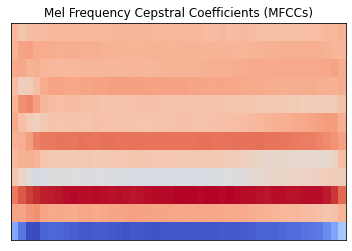

array([  3.55685415,  50.66604824, -28.58913946, -13.93140046,
        23.26184366,  -4.86193366,  -7.64896351,   4.03582378,
         1.15785633,   0.95948295,  -4.01684167])

In [5]:
plt.title('Mel Frequency Cepstral Coefficients (MFCCs)')
mfcc = librosa.feature.mfcc(sustfiltered, n_mfcc=13, n_mels=24, htk=True, n_fft=2048, hop_length=512)
mfcc = mfcc[1:]
librosa.display.specshow(mfcc)
plt.show()

# Remove higher DCT coefficients because they represent fast changes in the filterbank energies and actually degrade ASR performance
mfcc = mfcc[1:] 
mfcc.mean(axis=1)

### Descriptive Features (DFs)

Spectral characteristics of different birds are varied and signal model is not known. Since bird sounds are musical in nature, time and frequency-based features, called as Descriptive Features, used in audio and music retrieval can be used for bird species recognition. These features are extensively used and described by Scheirer and Slaney (1997), Tzanetakis and Cook (1999), Park et al. (2005) and Kim et al. (2006) for music and audio retrieval, and Somervuo et al. (2006) and Fagurland (2007) for recognition of bird species. 

In this the study, the following features are used. 

- Energy (EN)
- Zero Crossing Rate (ZCR)
- Duration of the Syllable (DUR) 
- Spectral Centroid (SC)
- Spectral Bandwidth (SB)
- Spectral Flux (SF)
- Spectral Roll Off (SRF)
- Spectral Flatness Measure (SFM)

>**Note:** other features are also presented in this notebook but have been discarded as they weren't helpful for the clustering task.

**Moments**

[Statistical moments](https://en.wikipedia.org/wiki/Moment_(mathematics)) plays a crucial role while we specify our probability distribution to work with since, with the help of moments, we can describe the properties of statistical distribution. In mathematics, the moments of a function are quantitative measures related to the shape of the function's graph. If the function is a probability distribution, then the first moment is the expected value, the second central moment is the variance, the third standardized moment is the skewness, and the fourth standardized moment is the kurtosis. The mathematical concept is closely related to the concept of moment in physics. Here, we will focus on the two first moments: mean and variance.

In [6]:
def moments(X, axis=0):
    return np.nanmean(X, axis), np.nanvar(X, axis)

#### Time Domain Features (TDF)

**Energy (EN)**

Compute moments of the energy envelope of the sound that reflects the aptitude of the birdsong.

In [7]:
# Compute sound envelope using the Hilbert transform 
energy = np.abs(hilbert(interfiltered))
moments(energy)

(0.009310785118377669, 7.808525387462641e-05)

**Energy Entropy (EE)**

Compute the entropy of the amplitude envelope of the audio signal. It is worth noting that sustained bird syllables with an almost flat envelope will show a very high temporal entropy, therefore we have computed the entropy on the distribution obtained with a histogram.

In [8]:
def EE(signal, bins=30, axis=0):
    # Compute sound envelope using the Hilbert transform 
    env = abs(hilbert(signal)) 
    # Normalize envelope
    env = env / env.sum(axis=axis, keepdims=True) 
    # Compute the entropy on the distribution obtained with a histogram to get low entropy on sustained syllables
    counts, bins = np.histogram(env,bins=bins)
    # Compute Shannon entropy
    te = -(bins * np.log(bins)).sum(axis=axis)
    return te

EE(interfiltered)

0.05353714948550231

**Zero Crossing Rate (ZCR)** 

Compute moments of the Zero Crossing Rate which provides information about the noisiness of the audio signals

In [9]:
zcr = librosa.feature.zero_crossing_rate(interfiltered, frame_length=512, hop_length=256)[0]
moments(zcr)

(0.35096153846153844, 0.002674181785809218)

**Duration of the Syllable (DUR)**

In [10]:
# Keep syllables under 3 seconds 
df = df.loc[df.duration <= 3]
# Reset the dataframe index
df = df.reset_index(drop=True)
print(f'Found {len(df.index)} syllables in csv')

df['duration'].head()

Found 4133 syllables in csv


0    0.549
1    0.571
2    0.581
3    0.562
4    0.512
Name: duration, dtype: float64

**Peak Picking Strategy (PPS)**

Design a Peak Picking Strategy (PPS) to dectect the equivalent steady state of energy with the onsets which go along with a sudden increase in the energy released by a bird syllable. Based on this assumption, a straightforward way to detect these onsets is to compute the [Root Mean Square (RMS)](https://en.wikipedia.org/wiki/Root_mean_square) energy value for each filtered frame of the audio samples and to isolate energy peaks with a smoothing filter. 

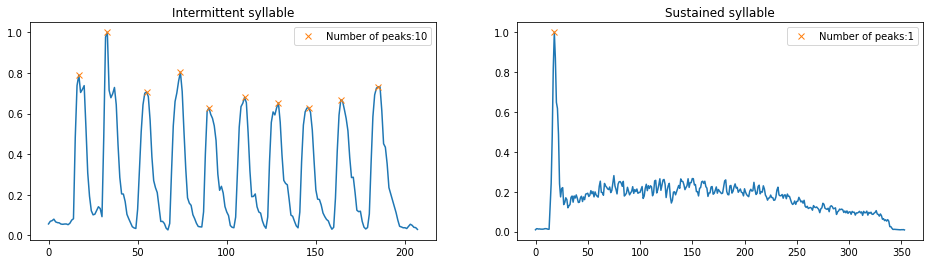

In [11]:
# Compute RMS with librosa
interrms = librosa.feature.rms(y=interfiltered, frame_length=128, hop_length=64)[0]
sustrms = librosa.feature.rms(y=sustfiltered, frame_length=128, hop_length=64)[0]

# Normalize rms and find peaks
norm_interrms = interrms / max(interrms)
interpeaks, _ = find_peaks(norm_interrms, prominence=0.4)
norm_sustrms = sustrms / max(sustrms)
sustpeaks, _ = find_peaks(norm_sustrms, prominence=0.4)

fig, ax = plt.subplots(1, 2, figsize=(16,4))
ax[0].plot(norm_interrms)
ax[0].plot(interpeaks, norm_interrms[interpeaks], "x", label=f'Number of peaks:{len(interpeaks)}')
ax[0].set_title('Intermittent syllable')
ax[0].legend()
ax[1].plot(norm_sustrms)
ax[1].plot(sustpeaks, norm_sustrms[sustpeaks], "x", label=f'Number of peaks:{len(sustpeaks)}')
ax[1].set_title('Sustained syllable')
ax[1].legend();

Finally, we can design the PPS function and compute some additional information regarding the peaks:
- Number of peaks
- Minimum peak interval
- Maximum peak interval
- First peak interval
- Last peak interval
- Minimum peak height
- Peak median rate

In [12]:
def PPS(signal, prominence=0.4, frame_length=128, sr=22050):
    # Calculate root mean square energy
    rms = librosa.feature.rms(y=signal, frame_length=128, hop_length=64)[0]
    # Normalize rms 
    norm_rms = rms / max(rms)
    peaks, peaks_info = find_peaks(norm_rms, prominence=prominence)   
    # Number of peaks
    n_peaks = len(peaks)
    
    if n_peaks == 0:
        interval_min = np.nan
        interval_max = np.nan
        interval_first = np.nan
        interval_last = np.nan
        height_min = np.nan
        medianpeaksrate = np.nan        
    elif n_peaks == 1:
        interval_min = 0
        interval_max = 0
        interval_first = 0
        interval_last = 0
        height_min = np.min(peaks_info['prominences'])
        medianpeaksrate = 0   
    else:
        # Convert peaks to seconds
        peaks = peaks / sr*frame_length
        # Peaks intervals
        interval_min = np.min(np.diff(peaks))
        interval_max = np.max(np.diff(peaks))
        interval_first = peaks[1] - peaks[0]
        interval_last = peaks[-1] - peaks[-2]
        # Peaks heights
        height_min = np.min(peaks_info['prominences'])
        # Peaks rate
        medianpeaksrate = 1/np.median(np.diff(peaks))
        
    return n_peaks, interval_min, interval_max, interval_first, interval_last, height_min, medianpeaksrate

intern_peaks, interinterval_min, interinterval_max, interinterval_first, interinterval_last, interheight_min, intermedianpeaksrate = PPS(interfiltered)
sustn_peaks, sustinterval_min, sustinterval_max, sustinterval_first, sustinterval_last, sustheight_min, sustmedianpeaksrate = PPS(sustfiltered)

print('{:<39} {:<39}'.format('Intermittent syllable','Sustained syllable'))
print(f'Number of peaks: {intern_peaks}', f'\t\t\tNumber of peaks: {sustn_peaks}')
print(f'Interval minimum: {interinterval_min}', f'\tInterval minimum: {sustinterval_min}')
print(f'Interval maximum: {interinterval_max}', f'\tInterval maximum: {sustinterval_max}')
print(f'Interval first: {interinterval_first}', f'\tInterval first: {sustinterval_first}')
print(f'Interval last: {interinterval_last}', f'\tInterval last: {sustinterval_last}')
print(f'Height minimum: {interheight_min}', f'\tHeight minimum: {sustheight_min}')
print(f'Median peaks rate: {intermedianpeaksrate}', f'\tMedian peaks rate: {sustmedianpeaksrate}')

Intermittent syllable                   Sustained syllable                     
Number of peaks: 10 			Number of peaks: 1
Interval minimum: 0.09287981859410432 	Interval minimum: 0
Interval maximum: 0.1277097505668934 	Interval maximum: 0
Interval first: 0.09287981859410432 	Interval first: 0
Interval last: 0.12190476190476196 	Interval last: 0
Height minimum: 0.5859966150318997 	Height minimum: 0.9909693542851844
Median peaks rate: 9.066611842105264 	Median peaks rate: 0


On the other hand, the FDFs that provide the spectral features of the birdsong
#### Frequency Domain Features (FDF)

**Spectral Centroid (SC)**

Compute moments of the Spectral Centroid

In [13]:
SC = librosa.feature.spectral_centroid(y=interfiltered, sr=sr, n_fft=2048, hop_length=512)[0]
moments(SC)

(4528.385187269308, 173453.83408836642)

**Spectral Bandwidth (SB)**

Compute moments of the Spectral Bandwidth

In [14]:
SB = librosa.feature.spectral_bandwidth(y=interfiltered, sr=sr,  n_fft=2048, hop_length=512)[0]
moments(SB)

(1613.2599902637173, 21804.013121754626)

**Spectral Flux (SF)**

Compute moments of the Spectral Flux

In [15]:
SF = librosa.onset.onset_strength(y=interfiltered, sr=sr, n_fft=2048, hop_length=512)
moments(SF)

(0.681716639070456, 0.5157996129638154)

**Spectral Roll-Off (SR)**

Compute moments of the Spectral Roll-Off

In [16]:
SR = librosa.feature.spectral_rolloff(y=interfiltered, sr=sr, n_fft=2048, hop_length=512)[0]
moments(SR)

(5511.671799879808, 723784.1445630824)

**Spectral Flatness Measure (SFM)**

Compute moments of the Spectral Flatness (Wiener entropy) to estimate the uniformity of signal energy distribution in the frequency domain

In [17]:
SFM = librosa.feature.spectral_flatness(y=interfiltered, n_fft=2048, hop_length=512)[0]
moments(SFM)

(0.0013618929071681348, 9.611026987359474e-06)

**Spectral Entropy (SE)**

Compute the entropy of the power spectrum of the audio signal.

In [18]:
def SE(signal, axis=0):
    # Compute absolute Fourier Transform
    S = np.abs(np.fft.rfft(signal))
    # Compute power spectrum
    S_pow = np.square(S)
    # Normalize power spectrum
    S_pow = S_pow / S_pow.sum(axis=axis, keepdims=True)
    # Compute Shannon entropy
    se = -(S_pow * np.log(S_pow)).sum(axis=axis)
    return se

SE(interfiltered)

5.780883151114413

#### Harmonic Features (HF)

It is found that bird vocalization is harmonic ([Jason R. Heller & John D. Pinezich, 2008](https://pubmed.ncbi.nlm.nih.gov/19045673/)). Therefore, the fundamental frequency (f0) and harmonic to noise ratio (HNR) can also be added to the proposed feature vector.

**Fundamental Frequency (f0)**

In [19]:
def f0(signal, sr, threshold=0, fmin=50, fmax=8000, frame_length=512, hop_length=256):
    # Original code from https://github.com/joachimpoutaraud/low-level-descriptors
    
    padding = [(0, 0) for _ in range(signal.ndim)]
    padding[-1] = (int(frame_length // 2), int(frame_length // 2))
    signal = np.pad(signal, padding, mode="edge")

    frames = librosa.util.frame(signal, frame_length=frame_length, hop_length=hop_length)
    
    f0 = []
    for i in frames:
        i = i - i.mean()    
        # Return maximum absolute value of the array
        amax = np.amax(np.abs(i)) 
        # Normalize the frame array between -1 and 1
        if amax > 0:
            i /= amax

            # Calculate autocorrelation function (acf) using numpy correlate
            acf = np.correlate(i, i, mode='full')
            acf = acf[acf.shape[0]//2:] # keep only the positive part

            # Find the location of the first autocorrelation's peak indice
            diff = np.diff(acf) # calculate autocorrelation's discrete difference
            peak_indices = np.where(diff > 0)[0] # return the indices of the peaks (positive discrete difference values)

            if peak_indices.shape[0] > 0:
                first_peak_indice = peak_indices[0] # return the indice of the first autocorrelation peak 

                # Find the location of the maximum autocorrelation's peak indice
                T0 = np.argmax(acf[first_peak_indice:]) + first_peak_indice # return the indice of the fundamental period
                max_peak = acf[T0] / acf[acf.argmax()] # normalize the maximum autocorrelation peak value
                f = sr / T0 # get the fundamental frequency

                if max_peak > threshold and f >= fmin and f <= fmax:
                    f0.append(f)
                else:
                    pass
            else:
                pass
        else:
            pass
    return f0

# Load original sampling rate
inter_sr = librosa.get_samplerate(df['file-name'][35])
x, sr = librosa.load(df['file-name'][35], sr=inter_sr)
intermittent = x[df.start[35]:df.end[35]]
# Filter the syllable according to Güttinger
interdenoised = filtering(intermittent)

moments(f0(interfiltered, inter_sr))

(2977.311120809581, 2272107.9714175933)

**Harmonic to Noise Ratio (HNR)**

In [20]:
def HNR(signal, frame_length=512, hop_length=256):
    # Original code from https://github.com/joachimpoutaraud/low-level-descriptors    
    padding = [(0, 0) for _ in range(signal.ndim)]
    padding[-1] = (int(frame_length // 2), int(frame_length // 2))
    signal = np.pad(signal, padding, mode="edge")

    frames = librosa.util.frame(signal, frame_length=frame_length, hop_length=hop_length)
    hnr = []
    for i in frames:
        # Return maximum absolute value of the frame array
        i = i - i.mean()
        amax = np.amax(np.abs(i)) 
        # Normalize the frame array between -1 and 1
        if amax > 0:
            i /= amax

            # Calculate autocorrelation function (acf) using numpy correlate
            acf = np.correlate(i, i, mode='full')
            acf = acf[acf.shape[0]//2:] # keep only the positive part

            # Find the location of the first autocorrelation's peak indice
            diff = np.diff(acf) # calculate autocorrelation's discrete difference
            peak_indices = np.where(diff > 0)[0] # return the indices of the peaks (positive discrete difference values)

            if peak_indices.shape[0] > 0:
                first_peak_indice = peak_indices[0] # return the indice of the first autocorrelation peak
                
                # Calculate the harmonic to noise ratio (hnr)
                T0 = np.argmax(acf[first_peak_indice:]) + first_peak_indice # return the indice of the fundamental period
                hnr.append(10.0 * np.log10(acf[T0] / (acf[acf.argmax()] - acf[T0])))
                
            else:
                pass
        else:
            pass
    return hnr

moments(HNR(interfiltered))

(-5.0575214575552145, 2.4398252738475463)

### Extracting audio features
Finally, we can process all the audio files and store their time and frequency domain features in a csv file.

In [ ]:
# Create new columns for the audio features
# MFCCs
df['MFCC1'] = None
df['MFCC2'] = None
df['MFCC3'] = None
df['MFCC4'] = None
df['MFCC5'] = None
df['MFCC6'] = None
df['MFCC7'] = None
df['MFCC8'] = None
df['MFCC9'] = None
df['MFCC10'] = None
df['MFCC11'] = None
df['MFCC12'] = None

# TIME DOMAIN FEATURES
df['ENm'] = None
df['ENv'] = None
df['ZCRm'] = None
df['ZCRv'] = None
# df['EE'] = None

# # PPS
# df['Peaks'] = None
# df['PeaksIntervalMin'] = None
# df['PeaksIntervalMax'] = None
# df['PeaksIntervalFirst'] = None
# df['PeaksIntervalLast'] = None
# df['PeaksHeightMin'] = None
# df['PeaksMedianRate'] = None 

# FREQUENCY DOMAIN FEATURES
df['SCm'] = None
df['SCv'] = None
df['SBm'] = None
df['SBv'] = None
df['SFm'] = None
df['SFv'] = None
df['SRm'] = None
df['SRv'] = None
df['SFMm'] = None
df['SFMv'] = None
# df['SE'] = None

# # HARMONIC FEATURES
# df['f0m'] = None
# df['f0v'] = None
# df['HNRm'] = None
# df['HNRv'] = None

for i in tqdm(range(len(df.index))): 

    # Load audio file 
    y, sr = librosa.load(df['file-name'][i], sr=22050)
    syllable = y[df.start[i]:df.end[i]]
    # Denoise syllable with Daubechies wavelet
    filtered = filtering(syllable)

    ### MFCCs
    mfcc = librosa.feature.mfcc(filtered, n_mfcc=13, n_mels=24, htk=True, n_fft=2048, hop_length=512)
    # Remove higher DCT coefficients because they represent fast changes in the filterbank energies and actually degrade ASR performance
    mfcc = mfcc[1:] 
    mfcc = mfcc.mean(axis=1)

    df['MFCC1'][i] = mfcc[0]
    df['MFCC2'][i] = mfcc[1]
    df['MFCC3'][i] = mfcc[2]
    df['MFCC4'][i] = mfcc[3]
    df['MFCC5'][i] = mfcc[4]
    df['MFCC6'][i] = mfcc[5]
    df['MFCC7'][i] = mfcc[6]
    df['MFCC8'][i] = mfcc[7]
    df['MFCC9'][i] = mfcc[8]
    df['MFCC10'][i] = mfcc[9]
    df['MFCC11'][i] = mfcc[10]
    df['MFCC12'][i] = mfcc[11]
    
    ### TIME DOMAIN FEATURES
    energy = np.abs(hilbert(filtered))
    EN = moments(energy)
    df['ENm'][i] = EN[0]
    df['ENv'][i] = EN[1]

    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=512, hop_length=256)[0]
    zcr = moments(zcr)
    df['ZCRm'][i] = zcr[0]
    df['ZCRv'][i] = zcr[1]
    
#     df['EE'][i] = EE(filtered)

#      Compute Pick Peacking Strategy (PPS)
#     n_peaks, interval_min, interval_max, interval_first, interval_last, height_min, medianpeaksrate = PPS(filtered, sr=sr)
#     df['Peaks'][i] = n_peaks
#     df['PeaksIntervalMin'][i] = interval_min
#     df['PeaksIntervalMax'][i] = interval_max
#     df['PeaksIntervalFirst'][i] = interval_first
#     df['PeaksIntervalLast'][i] = interval_last
#     df['PeaksHeightMin'][i] = height_min
#     df['PeaksMedianRate'][i] = medianpeaksrate 

    ### FREQUENCY DOMAIN FEATURES
    SC = librosa.feature.spectral_centroid(y=filtered, sr=sr, n_fft=2048, hop_length=512)[0]
    cent = moments(SC)
    df['SCm'][i] = cent[0]
    df['SCv'][i] = cent[1] 
    
    SB = librosa.feature.spectral_bandwidth(y=filtered, sr=sr,  n_fft=2048, hop_length=512)[0]
    band = moments(SB)
    df['SBm'][i] = band[0]
    df['SBv'][i] = band[1]

    SF = librosa.onset.onset_strength(y=filtered, sr=sr, n_fft=2048, hop_length=512)
    flux = moments(SF)
    df['SFm'][i] = flux[0]
    df['SFv'][i] = flux[1]   
    
    SR = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=2048, hop_length=512)[0]
    roll = moments(SR)
    df['SRm'][i] = roll[0]
    df['SRv'][i] = roll[1]

    SFM = librosa.feature.spectral_flatness(y=filtered, n_fft=2048, hop_length=512)[0]
    flat = moments(SFM)
    df['SFMm'][i] = flat[0]
    df['SFMv'][i] = flat[1]
    
#     df['SE'][i] = SE(filtered)

#     # HARMONIC FEATURES
#     original_sr = librosa.get_samplerate(df['file-name'][i]) # Load original sampling rate
#     x, original_sr = librosa.load(df['file-name'][i], sr=original_sr)
#     syllable_f0 = x[df.start[i]:df.end[i]]
#     # Denoise the syllable 
#     filtered_f0 = filtering(syllable_f0)

#     freq = moments(f0(filtered_f0, original_sr))

#     df['f0m'][i] = freq[0]
#     df['f0v'][i] = freq[1]

#     hnr = moments(HNR(filtered))

#     df['HNRm'][i] = hnr[0]
#     df['HNRv'][i] = hnr[1]

# Updated and save the dataframe
df.to_csv('dataset.csv', index=False)

Load the updated `dataset.csv` file and show the extracted features. 

In [22]:
df = pd.read_csv('dataset.csv')
print(f'Found {len(df.index)} syllables in csv')
df_features = df.iloc[:, 8:]
df_features.head()

Found 4133 syllables in csv


,duration,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,...,SCm,SCv,SBm,SBv,SFm,SFv,SRm,SRv,SFMm,SFMv
0,0.549,-109.481958,2.474112,48.374942,-20.190026,-21.349509,22.027669,4.836637,-19.319112,10.261311,...,4704.694674,357332.539106,1709.182879,49979.930391,0.888162,1.008821,6320.443726,1.303338e+06,0.002201,0.000019
1,0.571,-124.321819,-13.316125,55.665256,-7.335846,-24.810362,7.351164,10.126267,-2.886359,-6.360926,...,4894.594990,123823.953408,1903.750012,16588.690002,1.478772,1.929453,6885.457031,4.002580e+05,0.005412,0.000030
2,0.581,-118.811872,-16.306968,55.360652,-6.264549,-24.322579,6.051968,11.284524,-4.387789,-5.237668,...,4699.412453,190309.299218,1817.679751,27431.162664,1.482830,2.016139,6284.382512,8.548969e+05,0.009392,0.000515
3,0.562,-123.582189,-13.492028,56.402909,-7.246422,-27.307025,10.241175,9.205721,-2.900979,-6.563202,...,4807.354395,102161.378437,1904.473960,14730.848980,1.487784,2.005177,6751.089844,5.392537e+05,0.004954,0.000042
4,0.512,-118.616751,-12.580760,54.472028,-7.582635,-26.822244,10.891599,9.429326,-4.431579,-5.880217,...,4798.271899,162268.012722,1917.163729,27450.507078,1.588638,2.743882,6797.470491,9.439857e+05,0.006289,0.000105
